## 第6章Logistic回归与最大熵模型-习题

### 习题6.1
&emsp;&emsp;确认Logistic分布属于指数分布族。

**解答：**  
**第1步：**  
首先给出指数分布族的定义：  
对于随机变量$x$，在给定参数$\eta$下，其概率分别满足如下形式：$$p(x|\eta)=h(x)g(\eta)\exp(\eta^Tu(x))$$我们称之为**指数分布族**。  
其中：  
$x$：可以是标量或者向量，可以是离散值也可以是连续值  
$\eta$：自然参数  
$g(\eta)$：归一化系数  
$h(x),u(x)$：$x$的某个函数  

----

**第2步：**证明伯努利分布属于指数分布族  
伯努利分布：$\varphi$是$y=1$的概率，即$P(Y=1)=\varphi$  
$\begin{aligned}
P(y|\varphi) 
&= \varphi^y (1-\varphi)^{(1-y)} \\
&= (1-\varphi) \varphi^y (1-\varphi)^{(-y)} \\
&= (1-\varphi) (\frac{\varphi}{1-\varphi})^y \\
&= (1-\varphi) \exp\left(y \ln \frac{\varphi}{1-\varphi} \right) \\
&= \frac{1}{1+e^\eta} \exp (\eta y)
\end{aligned}$  
其中，$\displaystyle \eta=\ln \frac{\varphi}{1-\varphi} \Leftrightarrow \varphi = \frac{1}{1+e^{-\eta}}$  
将$y$替换成$x$，可得$\displaystyle P(x|\eta) = \frac{1}{1+e^\eta} \exp (\eta x)$
对比可知，伯努利分布属于指数分布族，其中$\displaystyle h(x) = 1, g(\eta)= \frac{1}{1+e^\eta}, u(x)=x$  

----

**第3步：**  
广义线性模型（GLM）必须满足三个假设：
1. $y | x;\theta \sim ExponentialFamily(\eta)$，即假设预测变量$y$在给定$x$，以$\theta$为参数的条件概率下，属于以$\eta$作为自然参数的指数分布族；  
2. 给定$x$，求解出以$x$为条件的$T(y)$的期望$E[T(y)|x]$，即算法输出为$h(x)=E[T(y)|x]$  
3. 满足$\eta=\theta^T x$，即自然参数和输入特征向量$x$之间线性相关，关系由$\theta$决定，仅当$\eta$是实数时才有意义，若$\eta$是一个向量，则$\eta_i=\theta_i^T x$

----

**第4步：**推导伯努利分布的GLM  
已知伯努利分布属于指数分布族，对给定的$x,\eta$，求解期望：$$\begin{aligned}
h_{\theta}(x) 
&= E[y|x;\theta] \\
&= 1 \cdot p(y=1)+ 0 \cdot p(y=0) \\
&= \varphi \\
&= \frac{1}{1+e^{-\eta}} \\
&= \frac{1}{1+e^{-\theta^T x}}
\end{aligned}$$可得到Logistic回归算法，故Logistic分布属于指数分布族，得证。

### 习题6.2
&emsp;&emsp;写出Logistic回归模型学习的梯度下降算法。

**解答：**  
对于Logistic模型：$$P(Y=1 | x)=\frac{\exp (w \cdot x+b)}{1+\exp (w \cdot x+b)} \\ P(Y=0 | x)=\frac{1}{1+\exp (w \cdot x+b)}
$$对数似然函数为：$\displaystyle L(w)=\sum_{i=1}^N \left[y_i (w \cdot x_i)-\log \left(1+\exp (w \cdot x_i)\right)\right]$  
似然函数求偏导，可得$\displaystyle \frac{\partial L(w)}{\partial w^{(j)}}=\sum_{i=1}^N\left[x_i^{(j)} \cdot y_i-\frac{\exp (w \cdot x_i) \cdot x_i^{(j)}}{1+\exp (w \cdot x_i)}\right]$  
梯度函数为：$\displaystyle \nabla L(w)=\left[\frac{\partial L(w)}{\partial w^{(0)}}, \cdots, \frac{\partial L(w)}{\partial w^{(m)}}\right]$  
Logistic回归模型学习的梯度下降算法：  
(1) 取初始值$x^{(0)} \in R$，置$k=0$  
(2) 计算$f(x^{(k)})$  
(3) 计算梯度$g_k=g(x^{(k)})$，当$\|g_k\| < \varepsilon$时，停止迭代，令$x^* = x^{(k)}$；否则，求$\lambda_k$，使得$\displaystyle f(x^{(k)}+\lambda_k g_k) = \max_{\lambda \geqslant 0}f(x^{(k)}+\lambda g_k)$  
(4) 置$x^{(k+1)}=x^{(k)}+\lambda_k g_k$，计算$f(x^{(k+1)})$，当$\|f(x^{(k+1)}) - f(x^{(k)})\| < \varepsilon$或 $\|x^{(k+1)} - x^{(k)}\| < \varepsilon$时，停止迭代，令$x^* = x^{(k+1)}$  
(5) 否则，置$k=k+1$，转(3)

In [1]:
%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import mpl

# 图像显示中文
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']

class LogisticRegression:
    def __init__(self, learn_rate=0.1, max_iter=10000, tol=1e-2):
        self.learn_rate = learn_rate  # 学习率
        self.max_iter = max_iter  # 迭代次数
        self.tol = tol  # 迭代停止阈值
        self.w = None  # 权重

    def preprocessing(self, X):
        """将原始X末尾加上一列，该列数值全部为1"""
        row = X.shape[0]
        y = np.ones(row).reshape(row, 1)
        X_prepro = np.hstack((X, y))
        return X_prepro

    def sigmod(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X_train, y_train):
        X = self.preprocessing(X_train)
        y = y_train.T
        # 初始化权重w
        self.w = np.array([[0] * X.shape[1]], dtype=np.float)
        k = 0
        for loop in range(self.max_iter):
            # 计算梯度
            z = np.dot(X, self.w.T)
            grad = X * (y - self.sigmod(z))
            grad = grad.sum(axis=0)
            # 利用梯度的绝对值作为迭代中止的条件
            if (np.abs(grad) <= self.tol).all():
                break
            else:
                # 更新权重w 梯度上升——求极大值
                self.w += self.learn_rate * grad
                k += 1
        print("迭代次数：{}次".format(k))
        print("最终梯度：{}".format(grad))
        print("最终权重：{}".format(self.w[0]))

    def predict(self, x):
        p = self.sigmod(np.dot(self.preprocessing(x), self.w.T))
        print("Y=1的概率被估计为：{:.2%}".format(p[0][0]))  # 调用score时，注释掉
        p[np.where(p > 0.5)] = 1
        p[np.where(p < 0.5)] = 0
        return p

    def score(self, X, y):
        y_c = self.predict(X)
        error_rate = np.sum(np.abs(y_c - y.T)) / y_c.shape[0]
        return 1 - error_rate

    def draw(self, X, y):
        # 分离正负实例点
        y = y[0]
        X_po = X[np.where(y == 1)]
        X_ne = X[np.where(y == 0)]
        # 绘制数据集散点图
        ax = plt.axes(projection='3d')
        x_1 = X_po[0, :]
        y_1 = X_po[1, :]
        z_1 = X_po[2, :]
        x_2 = X_ne[0, :]
        y_2 = X_ne[1, :]
        z_2 = X_ne[2, :]
        ax.scatter(x_1, y_1, z_1, c="r", label="正实例")
        ax.scatter(x_2, y_2, z_2, c="b", label="负实例")
        ax.legend(loc='best')
        # 绘制p=0.5的区分平面
        x = np.linspace(-3, 3, 3)
        y = np.linspace(-3, 3, 3)
        x_3, y_3 = np.meshgrid(x, y)
        a, b, c, d = self.w[0]
        z_3 = -(a * x_3 + b * y_3 + d) / c
        ax.plot_surface(x_3, y_3, z_3, alpha=0.5)  # 调节透明度
        plt.show()

迭代次数：3232次
最终梯度：[ 0.00144779  0.00046133  0.00490279 -0.00999848]
最终权重：[  2.96908597   1.60115396   5.04477438 -13.43744079]


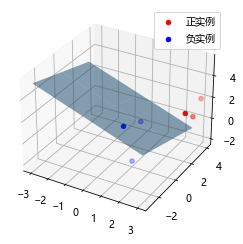

In [2]:
# 训练数据集
X_train = np.array([[3, 3, 3], [4, 3, 2], [2, 1, 2], [1, 1, 1], [-1, 0, 1], [2, -2, 1]])
y_train = np.array([[1, 1, 1, 0, 0, 0]])
# 构建实例，进行训练
clf = LogisticRegression()
clf.fit(X_train, y_train)
clf.draw(X_train, y_train)

### 习题6.3
&emsp;&emsp;写出最大熵模型学习的DFP算法。（关于一般的DFP算法参见附录B）

**解答：**  
**第1步：**  
最大熵模型为：$$
\begin{array}{cl}
{\max } & {H(p)=-\sum_{x, y} P(x) P(y | x) \log P(y | x)} \\ 
{\text {st.}} &
{E_p(f_i)-E_{\hat{p}}(f_i)=0, \quad i=1,2, \cdots,n} \\ 
& {\sum_y P(y | x)=1}
\end{array}$$引入拉格朗日乘子，定义拉格朗日函数：$$
L(P, w)=\sum_{xy} P(x) P(y | x) \log P(y | x)+w_0 \left(1-\sum_y P(y | x)\right) \\
+\sum_{i=1} w_i\left(\sum_{xy} P(x, y) f_i(x, y)-\sum_{xy} P(x, y) P(y | x) f_i(x, y)\right)$$
最优化原始问题为：$$\min_{P \in C} \max_{w} L(P,w)$$对偶问题为：$$\max_{w} \min_{P \in C} L(P,w)$$令$$\Psi(w) = \min_{P \in C} L(P,w) = L(P_w, w)$$$\Psi(w)$称为对偶函数，同时，其解记作$$P_w = \mathop{\arg \min}_{P \in C} L(P,w) = P_w(y|x)$$求$L(P,w)$对$P(y|x)$的偏导数，并令偏导数等于0，解得：$$P_w(y | x)=\frac{1}{Z_w(x)} \exp \left(\sum_{i=1}^n w_i f_i (x, y)\right)$$其中：$$Z_w(x)=\sum_y \exp \left(\sum_{i=1}^n w_i f_i(x, y)\right)$$则最大熵模型目标函数表示为$$\varphi(w)=\min_{w \in R_n} \Psi(w) = \sum_{x} P(x) \log \sum_{y} \exp \left(\sum_{i=1}^{n} w_{i} f_{i}(x, y)\right)-\sum_{x, y} P(x, y) \sum_{i=1}^{n} w_{i} f_{i}(x, y)$$  

**第2步：**  
DFP的$G_{k+1}$的迭代公式为：$$G_{k+1}=G_k+\frac{\delta_k \delta_k^T}{\delta_k^T y_k}-\frac{G_k y_k y_k^T G_k}{y_k^T G_k y_k}$$  
**最大熵模型的DFP算法：**   
输入：目标函数$\varphi(w)$，梯度$g(w) = \nabla g(w)$，精度要求$\varepsilon$；  
输出：$\varphi(w)$的极小值点$w^*$  
(1)选定初始点$w^{(0)}$，取$G_0$为正定对称矩阵，置$k=0$  
(2)计算$g_k=g(w^{(k)})$，若$\|g_k\| < \varepsilon$，则停止计算，得近似解$w^*=w^{(k)}$，否则转(3)  
(3)置$p_k=-G_kg_k$  
(4)一维搜索：求$\lambda_k$使得$$\varphi\left(w^{(k)}+\lambda_k P_k\right)=\min _{\lambda \geqslant 0} \varphi\left(w^{(k)}+\lambda P_{k}\right)$$(5)置$w^{(k+1)}=w^{(k)}+\lambda_k p_k$  
(6)计算$g_{k+1}=g(w^{(k+1)})$，若$\|g_{k+1}\| < \varepsilon$，则停止计算，得近似解$w^*=w^{(k+1)}$；否则，按照迭代式算出$G_{k+1}$  
(7)置$k=k+1$，转(3)  